## Libraries

In [41]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

## Data load

In [42]:
red = pd.read_csv("data/winequality-red.csv", delimiter=';')
white = pd.read_csv("data/winequality-red.csv", delimiter=';')

## Data Prep/Clean

In [43]:
# Add new column 'red' to combine the two dataframes
red['red'] = 1

In [44]:
# Add new column 'red' to combine the two dataframes
white['red'] = 0

In [45]:
# Merge two data frames
df = pd.concat([red,white], axis=0)
df = shuffle(df, random_state = 31337).reset_index().drop(columns = ['index'])

In [46]:
# Remove Spaces in Column Names
df = df.rename(columns={'fixed acidity':'fixed_acidity'})
df = df.rename(columns={'volatile acidity':'volatile_acidity'})
df = df.rename(columns={'citric acid':'citric_acid'})
df = df.rename(columns={'residual sugar':'residual_sugar'})
df = df.rename(columns={'free sulfur dioxide':'free_sulfur_dioxide'})
df = df.rename(columns={'total sulfur dioxide':'total_sulfur_dioxide'})

## Exploration and Visualization

In [47]:
df.describe().round(2).T

count   mean    std   min    25%    50%    75%     max
fixed_acidity         3198.0   8.32   1.74  4.60   7.10   7.90   9.20   15.90
volatile_acidity      3198.0   0.53   0.18  0.12   0.39   0.52   0.64    1.58
citric_acid           3198.0   0.27   0.19  0.00   0.09   0.26   0.42    1.00
residual_sugar        3198.0   2.54   1.41  0.90   1.90   2.20   2.60   15.50
chlorides             3198.0   0.09   0.05  0.01   0.07   0.08   0.09    0.61
free_sulfur_dioxide   3198.0  15.87  10.46  1.00   7.00  14.00  21.00   72.00
total_sulfur_dioxide  3198.0  46.47  32.89  6.00  22.00  38.00  62.00  289.00
density               3198.0   1.00   0.00  0.99   1.00   1.00   1.00    1.00
pH                    3198.0   3.31   0.15  2.74   3.21   3.31   3.40    4.01
sulphates             3198.0   0.66   0.17  0.33   0.55   0.62   0.73    2.00
alcohol               3198.0  10.42   1.07  8.40   9.50  10.20  11.10   14.90
quality               3198.0   5.64   0.81  3.00   5.00   6.00   6.00    8.00
red                   3198.0   0.50   0.50  0.00   0.00   0.50   1.00    1.00

In [48]:
cor = df.corr().round(2)
cor.sort_values(['quality'],ascending=False,inplace=True)
cor.quality

quality                 1.00
alcohol                 0.48
sulphates               0.25
citric_acid             0.23
fixed_acidity           0.12
residual_sugar          0.01
red                     0.00
free_sulfur_dioxide    -0.05
pH                     -0.06
chlorides              -0.13
density                -0.17
total_sulfur_dioxide   -0.19
volatile_acidity       -0.39
Name: quality, dtype: float64

In [49]:
# Check Target Variable
df['quality'].unique()

array([7, 5, 6, 4, 3, 8], dtype=int64)

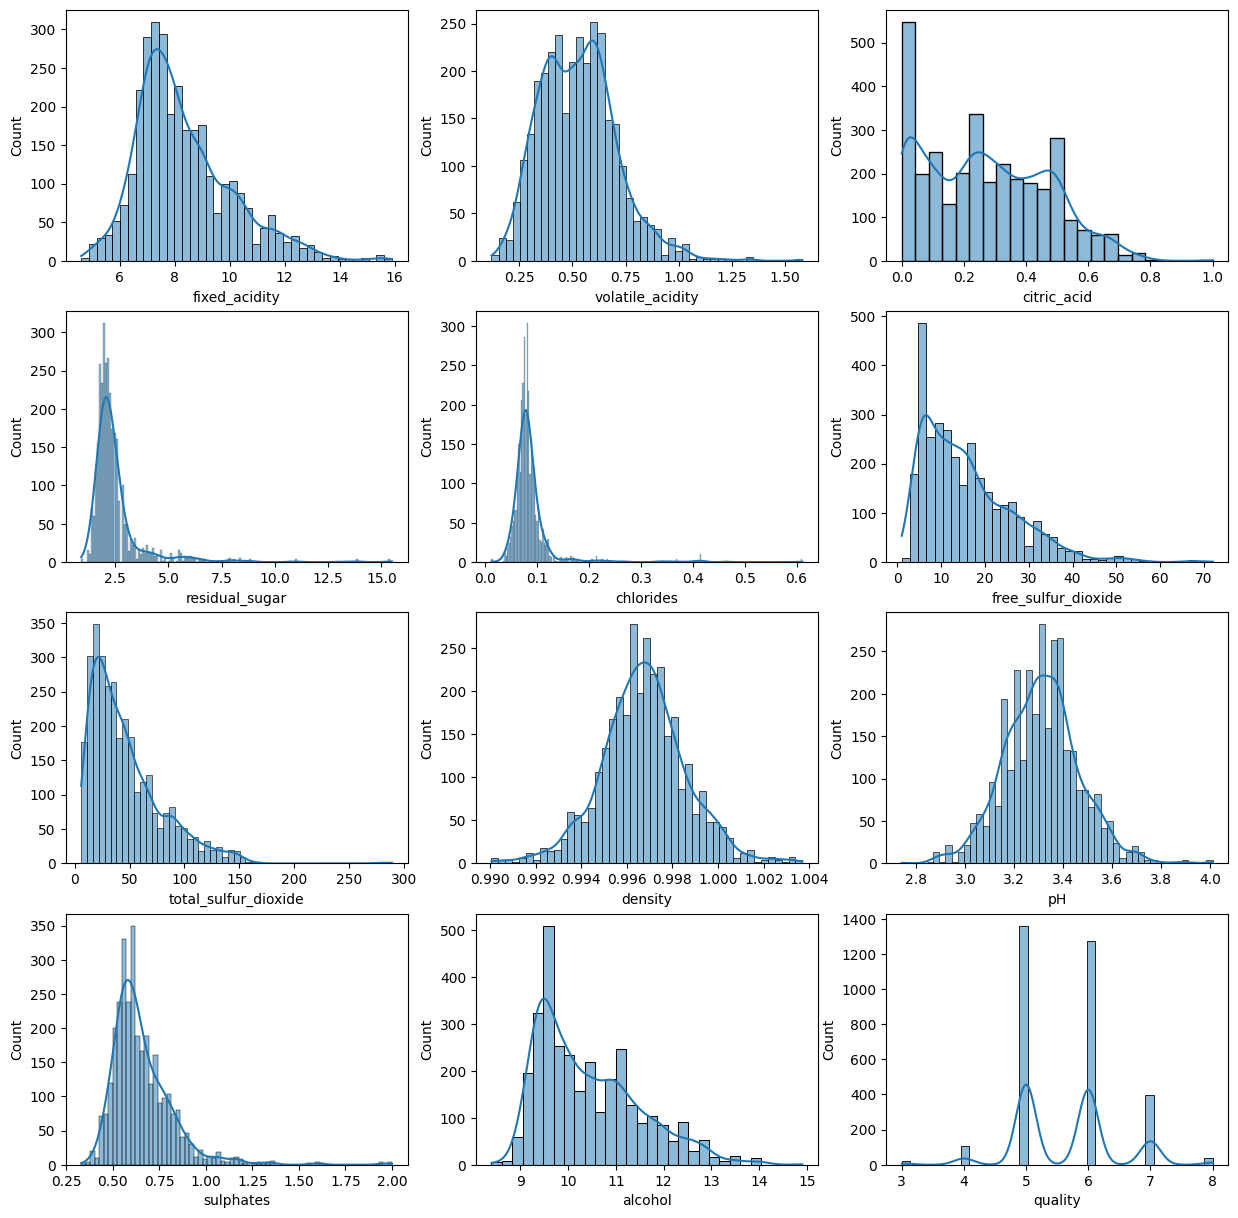

In [50]:
# select the columns to be plotted
cols = df.drop(columns=['red'])

# create the figure and axes
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(15, 15)  # ( x , y )
axes = axes.ravel()  # flattening the array makes indexing easier
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, ax = ax)

plt.show()

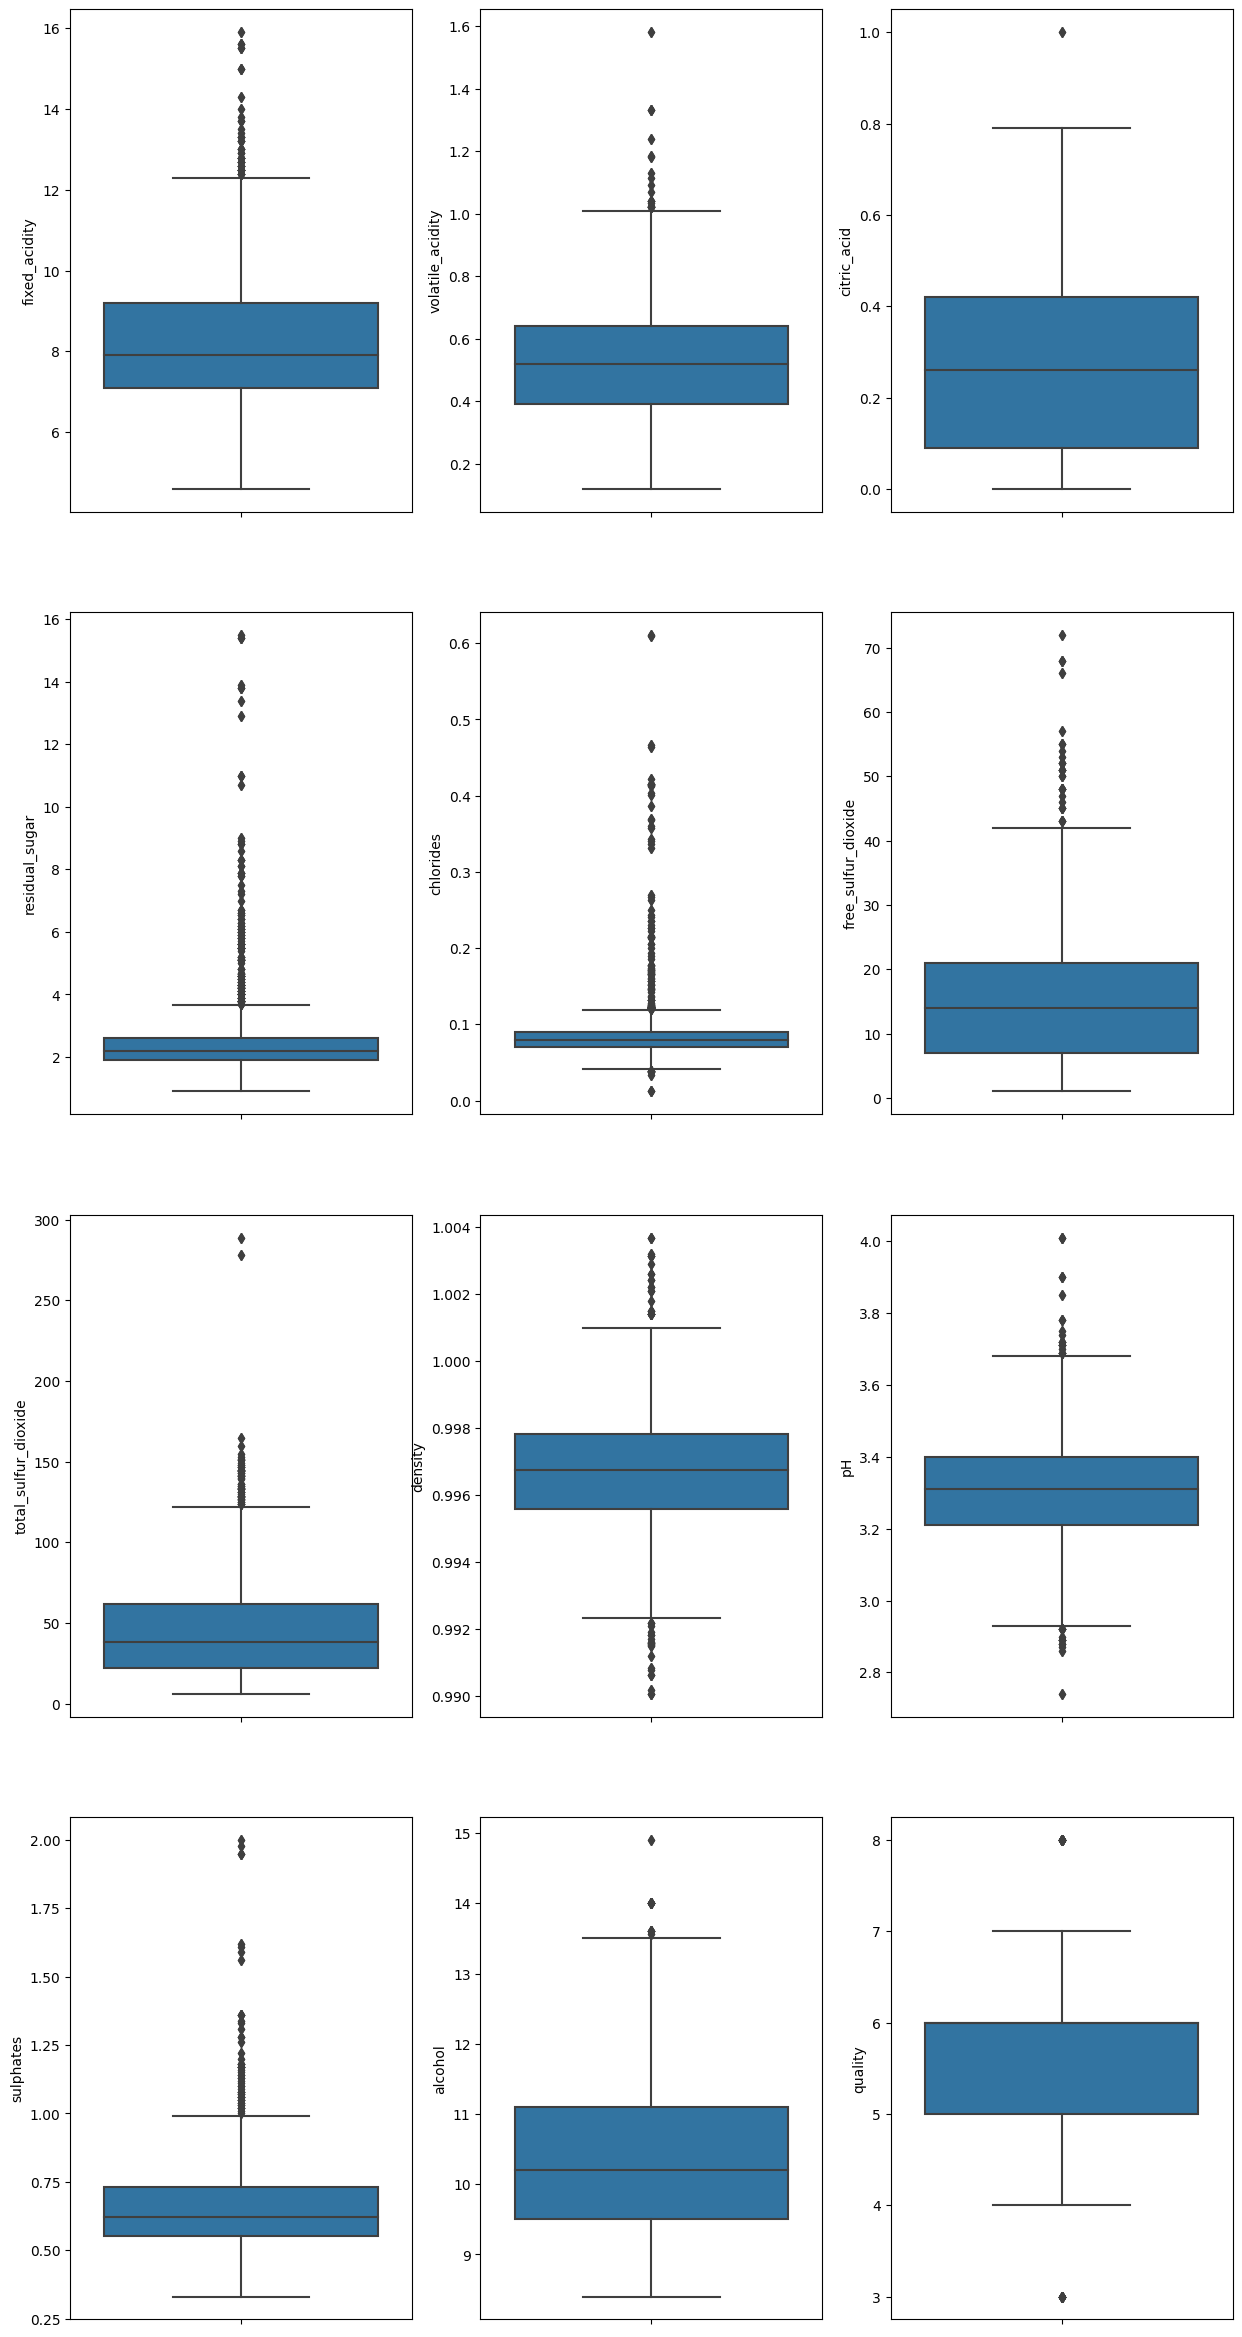

In [51]:
# create the figure and axes
fig, axes = plt.subplots(4, 3)
axes = axes.ravel()  # flattening the array makes indexing easier
fig.set_size_inches(15, 30)  # ( x , y )
for col, ax in zip(cols, axes):
    sns.boxplot(ax =ax,y=df[col])
plt.show()

## Data Transormation

**Outliers**

In [52]:
# Remove values outside +/- 1.5*IQR and replace with Column Mean
df_outliers = df.copy()

# Exclude Quality, as it's changing categorical to continuous
columns_to_iterate = [col for col in df_outliers.columns if col != 'quality']

for col in columns_to_iterate:
    # Calculate IQR
    q75, q25 = np.percentile(df_outliers[col], [75 ,25])
    IQR = q75 - q25

    # Calculate lower and upper bounds
    lower_bound = q25 - (IQR * 1.5)
    upper_bound = q75 + (IQR * 1.5)

    # Select rows that are outside the bounds
    outliers = df.query(f'{col} < {lower_bound} or {col} > {upper_bound}')
    
    # Replace values in column 'i' that are </> min/max with mean
    df_outliers[col] = np.where(df_outliers[col] > upper_bound, 
                              df_outliers[col].mean(), 
                              df_outliers[col])
    
    df_outliers[col] = np.where(df_outliers[col] < lower_bound, 
                              df_outliers[col].mean(), 
                              df_outliers[col])

In [53]:
# Quick View of Outlier transformation made
1 - df_outliers.describe().round(2).T/df.describe().round(2).T

count      mean       std       min  25%  50%       75%   
fixed_acidity           0.0  0.018029  0.143678  0.000000  0.0  0.0  0.021739  \
volatile_acidity        0.0  0.018868  0.055556  0.000000  0.0  0.0  0.015625   
citric_acid             0.0  0.000000  0.000000       NaN  0.0  0.0  0.000000   
residual_sugar          0.0  0.129921  0.687943  0.000000  0.0  0.0  0.023077   
chlorides               0.0  0.111111  0.800000 -3.000000  0.0  0.0  0.000000   
free_sulfur_dioxide     0.0  0.042218  0.126195  0.000000  0.0  0.0  0.000000   
total_sulfur_dioxide    0.0  0.072090  0.186683  0.000000  0.0  0.0  0.064516   
density                 0.0  0.000000       NaN  0.000000  0.0  0.0  0.000000   
pH                      0.0  0.000000  0.066667 -0.069343  0.0  0.0  0.000000   
sulphates               0.0  0.030303  0.294118  0.000000  0.0  0.0  0.027397   
alcohol                 0.0  0.002879  0.046729  0.000000  0.0  0.0  0.009009   
quality                 0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
red                     0.0  0.000000  0.000000       NaN  NaN  0.0  0.000000   

                           max  
fixed_acidity         0.226415  
volatile_acidity      0.360759  
citric_acid           0.210000  
residual_sugar        0.764516  
chlorides             0.803279  
free_sulfur_dioxide   0.416667  
total_sulfur_dioxide  0.577855  
density               0.000000  
pH                    0.082294  
sulphates             0.505000  
alcohol               0.093960  
quality               0.000000  
red                   0.000000

**Scale/Normalize**

In [54]:
# Import modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Move df_outliers to df
df_before_outlier = df.copy()
df = df_outliers.copy()

# Separate features and target variable
y = df['quality'].copy()
#X = df.drop('quality', axis=1) # all features
X = df[['alcohol','sulphates','citric_acid','volatile_acidity']] # Retain Correlated

# Get the list of names for numerical and categorical attributes separately
num_attributes = X.select_dtypes(exclude='object')

# Convert to list (mutable)
num_attribs = list(num_attributes)


# Numerical Pipeline to scale
pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# Run the transformation pipeline
X = pipeline.fit_transform(X)

**Test/Train Split**

In [55]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=6047)

In [56]:
if isinstance(X_train, pd.DataFrame):
    print('DType:\nX_train:{}, y_train:{}\nShape:\nX_train:{}, y_train:{}\nType:\nX_train:{}, y_train{}'
          .format(type(X_train),type(y_train),X_train.shape,y_train.shape,type(X_train),type(y_train)))
else:
    print('DType:\nX_train:{}, y_train:{}\nShape:\nX_train:{}, y_train:{}\nType:\nX_train:{}, y_train{}'
        .format(X_train.dtype,y_train.dtype,X_train.shape,y_train.shape,type(X_train),type(y_train)))
       

DType:
X_train:float64, y_train:int64
Shape:
X_train:(2398, 4), y_train:(2398,)
Type:
X_train:<class 'numpy.ndarray'>, y_train<class 'pandas.core.series.Series'>


## Modeling

**Logistic Regression Multi-class**

In [57]:
# Model Original
lgreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

In [58]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        21
           5       0.63      0.77      0.69       337
           6       0.52      0.54      0.53       323
           7       0.48      0.27      0.35        99
           8       0.00      0.00      0.00        14

    accuracy                           0.58       800
   macro avg       0.27      0.26      0.26       800
weighted avg       0.54      0.58      0.55       800



In [59]:
print(cm)

[[  0   0   6   0   0   0]
 [  0   0  12   9   0   0]
 [  0   0 258  79   0   0]
 [  0   0 124 176  23   0]
 [  0   0   7  65  27   0]
 [  0   0   0   8   6   0]]


**KNN**

In [60]:
# Model Original Data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [61]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.27      0.19      0.22        21
           5       0.70      0.78      0.74       337
           6       0.67      0.67      0.67       323
           7       0.64      0.57      0.60        99
           8       0.00      0.00      0.00        14

    accuracy                           0.67       800
   macro avg       0.38      0.37      0.37       800
weighted avg       0.65      0.67      0.66       800



In [62]:
print(cm)

[[  0   3   3   0   0   0]
 [  1   4  10   5   1   0]
 [  0   6 262  67   2   0]
 [  0   2  83 215  21   2]
 [  0   0  12  31  56   0]
 [  0   0   2   4   8   0]]


**Linear SVM**

In [63]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)

In [64]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        21
           5       0.63      0.78      0.70       337
           6       0.51      0.61      0.56       323
           7       0.00      0.00      0.00        99
           8       0.00      0.00      0.00        14

    accuracy                           0.58       800
   macro avg       0.19      0.23      0.21       800
weighted avg       0.47      0.58      0.52       800



In [65]:
print(cm)

[[  0   0   6   0   0   0]
 [  0   0  11  10   0   0]
 [  0   0 264  73   0   0]
 [  0   0 126 197   0   0]
 [  0   0  10  89   0   0]
 [  0   0   0  14   0   0]]


**SVM (RBF)**

In [66]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [67]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        21
           5       0.65      0.81      0.72       337
           6       0.55      0.57      0.56       323
           7       0.54      0.28      0.37        99
           8       0.00      0.00      0.00        14

    accuracy                           0.60       800
   macro avg       0.29      0.28      0.28       800
weighted avg       0.56      0.60      0.58       800



In [68]:
print(cm)

[[  0   0   6   0   0   0]
 [  0   0   9  12   0   0]
 [  0   0 272  65   0   0]
 [  0   0 123 183  17   0]
 [  0   0   8  63  28   0]
 [  0   0   0   7   7   0]]


**Naive Bayes**

In [69]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [70]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.33      0.05      0.08        21
           5       0.62      0.79      0.70       337
           6       0.55      0.44      0.49       323
           7       0.46      0.51      0.48        99
           8       0.00      0.00      0.00        14

    accuracy                           0.57       800
   macro avg       0.33      0.30      0.29       800
weighted avg       0.55      0.57      0.55       800



In [71]:
print(cm)

[[  0   0   6   0   0   0]
 [  0   1  10  10   0   0]
 [  0   1 266  61   9   0]
 [  0   1 135 143  44   0]
 [  0   0  10  39  50   0]
 [  0   0   0   8   6   0]]


**Decision Tree**    ## bestmodel

In [72]:
dt = DecisionTreeClassifier(criterion='gini')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

with open('data/wine_dt.pkl','wb') as file:
    pickle.dump(dt,file)

In [73]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.60      1.00      0.75         6
           4       0.83      0.90      0.86        21
           5       0.95      0.93      0.94       337
           6       0.92      0.91      0.92       323
           7       0.84      0.96      0.90        99
           8       1.00      0.43      0.60        14

    accuracy                           0.92       800
   macro avg       0.86      0.85      0.83       800
weighted avg       0.92      0.92      0.91       800



In [74]:
print(cm)

[[  6   0   0   0   0   0]
 [  0  19   0   0   2   0]
 [  2   2 312  21   0   0]
 [  2   2  15 294  10   0]
 [  0   0   0   4  95   0]
 [  0   0   2   0   6   6]]


**Random Forest**

In [75]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [76]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         6
           4       1.00      0.81      0.89        21
           5       0.94      0.94      0.94       337
           6       0.92      0.94      0.93       323
           7       0.92      0.96      0.94        99
           8       1.00      0.43      0.60        14

    accuracy                           0.93       800
   macro avg       0.96      0.85      0.88       800
weighted avg       0.93      0.93      0.93       800



In [77]:
print(cm)

[[  6   0   0   0   0   0]
 [  0  17   2   2   0   0]
 [  0   0 316  21   0   0]
 [  0   0  17 304   2   0]
 [  0   0   2   2  95   0]
 [  0   0   0   2   6   6]]


**XGBoost**

In [78]:
y_mapped = df['quality'].map({ 3:0, 4:1, 5:2, 6:3, 7:4, 8:5})
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y_mapped,random_state=31337)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [79]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.79      0.88        29
           2       0.91      0.94      0.92       341
           3       0.89      0.90      0.89       315
           4       0.90      0.88      0.89       100
           5       1.00      0.60      0.75        10

    accuracy                           0.90       800
   macro avg       0.95      0.78      0.85       800
weighted avg       0.90      0.90      0.90       800



In [80]:
print(cm)

[[  3   0   2   0   0   0]
 [  0  23   2   4   0   0]
 [  0   0 319  22   0   0]
 [  0   0  26 283   6   0]
 [  0   0   2  10  88   0]
 [  0   0   0   0   4   6]]
